In [98]:
import pandas as pd
pass_data = pd.read_csv("/Users/annadaugaard/Desktop/VFF/VFF_analytics_src/data/03_model_data/test_for_streamit.csv")
gps_data=  pd.read_csv("/Users/annadaugaard/Desktop/VFF/preprocessed_data_for_decision_making.csv", index_col=0)
gps_data_home = gps_data[gps_data["Team"]== "home"]

In [101]:
import pandas as pd
pass_data = pd.read_csv("/Users/annadaugaard/Desktop/VFF/VFF_analytics_src/data/03_model_data/test_for_streamit.csv")
gps_data=  pd.read_csv("/Users/annadaugaard/Desktop/VFF/preprocessed_data_for_decision_making.csv", index_col=0)
gps_data_home = gps_data[gps_data["Team"]== "home"]


# Step 1: subset pass_data to home team only
pass_data_home = pass_data[pass_data["Team"] == "home"].reset_index(drop=True)
pass_data_home = pass_data_home[pass_data_home["uncertainty"] < 2].reset_index(drop=True)
# Columns to keep from gps_data
gps_columns = ["time", "player_id", "player_num", "x", "y", "spd", "ball_x","ball_y","Team","acceleration", "smoothed_acceleration"]

# Prepare an empty DataFrame for extracted data
extracted_gps_data = pd.DataFrame(columns=gps_columns + ["pass_event_id"])

# Steps 2 & 3: Extract GPS data for each pass event
for idx, row in pass_data_home.iterrows():
    from_player = row["From"]
    start_time = row["Start Time [s]"]
    end_time = row["End Time [s]"]
    
    # Extract relevant gps data
    gps_subset = gps_data_home[
        (gps_data_home["player_num"] == from_player) &
        (gps_data_home["time"] >= start_time) &
        (gps_data_home["time"] <= end_time)
    ][gps_columns].copy()

    # Add pass event identifier
    gps_subset["pass_event_id"] = idx
    
    # Concatenate results
    extracted_gps_data = pd.concat([extracted_gps_data, gps_subset], ignore_index=True)

# Calculate distance to the ball
extracted_gps_data["distance_to_ball"] = np.hypot(
    extracted_gps_data["x"] - extracted_gps_data["ball_x"],
    extracted_gps_data["y"] - extracted_gps_data["ball_y"]
)

low_distance = extracted_gps_data[extracted_gps_data["distance_to_ball"] < 1]
# Assuming df is your DataFrame
df = low_distance.copy()

# Identify chunks by consecutive player_num
df['player_chunk'] = (df['player_num'] != df['player_num'].shift()).cumsum()

# Get index of max acceleration per chunk
max_acceleration_indices = df.groupby('player_chunk')['acceleration'].idxmax() - 6

# Initialize a list of zeros with length 2500
binary_list = [0] * len(extracted_gps_data)

for idx in max_acceleration_indices:
    if 0 <= idx < len(extracted_gps_data):
        binary_list[idx] = 1
        
    
extracted_gps_data["decision_making_point"] = binary_list

player_24_2 = extracted_gps_data[extracted_gps_data["player_num"].isin([24, 2])]

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_49233/4147419631.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extracted_gps_data = pd.concat([extracted_gps_data, gps_subset], ignore_index=True)


In [102]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point

# Robust overlap area calculation function
def calculate_overlap_area(target_x, target_y, x_ball, y_ball, away_players, angle_degrees=40, circle_radius=2):
    dx, dy = target_x - x_ball, target_y - y_ball
    height = np.hypot(dx, dy)
    if height == 0:
        return 0.0

    trajectory_angle = np.arctan2(dy, dx)
    half_angle_radians = np.radians(angle_degrees / 2)
    base_width = 2 * height * np.tan(half_angle_radians)

    left_x = target_x + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
    left_y = target_y + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
    right_x = target_x + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
    right_y = target_y + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

    points = [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)]

    triangle = Polygon(points)
    if not triangle.is_valid or triangle.area == 0:
        return 0.0

    total_overlap_area = sum(
        triangle.intersection(Point(away_x, away_y).buffer(circle_radius)).area
        for away_x, away_y in zip(away_players["x"], away_players["y"])
    )

    return total_overlap_area

# Updated custom scoring function with directional boost
def custom_score(overlap_area, distance_to_ball, ball_direction_x, alpha=1.0, beta=0.01, gamma=0.1):
    direction_bonus = gamma if ball_direction_x > 0 else -gamma
    penalty = alpha * overlap_area + beta * distance_to_ball
    return np.exp(-penalty + direction_bonus)

# Placeholder for results
results = []

# Iterate over each row in extracted_gps_data with decision-making points
decision_points = player_24_2[player_24_2["decision_making_point"] == 1].reset_index()

for idx, row in decision_points.iterrows():
    current_time = row["time"]
    current_player_num = row["player_num"]
    x_ball, y_ball = row["ball_x"], row["ball_y"]

    players_at_time = gps_data[(gps_data["time"] == current_time) & 
                               (gps_data["player_num"] != current_player_num)]

    home_players = players_at_time[players_at_time["Team"] == "home"]
    away_players = players_at_time[players_at_time["Team"] == "away"]

    for _, home_player in home_players.iterrows():
        
        ball_direction_x = x_ball -home_player["x"] 

        distance_to_ball = np.hypot(home_player["x"] - x_ball, home_player["y"] - y_ball)
        
        if distance_to_ball < 15:
            circle_radius = 2
        elif 15 < distance_to_ball <= 25:
            circle_radius =3
        else:
            circle_radius=6
        
        overlap_area = calculate_overlap_area(
                target_x=home_player["x"],
                target_y=home_player["y"],
                x_ball=x_ball,
                y_ball=y_ball,
                away_players=away_players,
                angle_degrees=40,
                circle_radius=circle_radius
            )
        # Using custom scoring with directional boost
        score = custom_score(overlap_area, distance_to_ball, ball_direction_x)

        results.append({
            "timestamp": current_time,
            "reference_player_num": current_player_num,
            "target_player_num": home_player["player_num"],
            "score": score
        })

results_df = pd.DataFrame(results)

# Convert to wide format
results_df_wide = results_df.pivot_table(
    index=['timestamp', 'reference_player_num'],
    columns='target_player_num',
    values='score'
).reset_index()

results_df_wide.columns = [
    f'score_to_player_{int(col)}' if isinstance(col, (int, float)) else col
    for col in results_df_wide.columns
]

# Select columns containing 'score_to_player'
score_columns = [col for col in results_df_wide.columns if 'score_to_player' in col]

# Find the max value per row among score columns
results_df_wide['max_score'] = results_df_wide[score_columns].max(axis=1)

# Find the corresponding player column for each max score
results_df_wide['max_score_player'] = results_df_wide[score_columns].idxmax(axis=1)

# Display the results
print(results_df_wide[['timestamp', 'reference_player_num', 'max_score', 'max_score_player']])

# Extract just the numeric player ID
results_df_wide['max_score_player'] = results_df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)


<>:116: SyntaxWarning: invalid escape sequence '\d'
<>:116: SyntaxWarning: invalid escape sequence '\d'
/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_49233/3904431351.py:116: SyntaxWarning: invalid escape sequence '\d'
  results_df_wide['max_score_player'] = results_df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)


    timestamp  reference_player_num  max_score    max_score_player
0       97.72                    24   0.799767  score_to_player_16
1      132.36                     2   0.930732  score_to_player_10
2      142.68                     2   0.933685  score_to_player_23
3      147.76                    24   0.942583  score_to_player_18
4      148.88                    24   1.089014  score_to_player_18
..        ...                   ...        ...                 ...
84    2278.64                    24   1.086256  score_to_player_18
85    2314.68                     2   0.768072  score_to_player_16
86    2317.40                    24   0.863643   score_to_player_2
87    2319.00                    24   1.089226  score_to_player_18
88    2531.32                    24   0.871756  score_to_player_18

[89 rows x 4 columns]


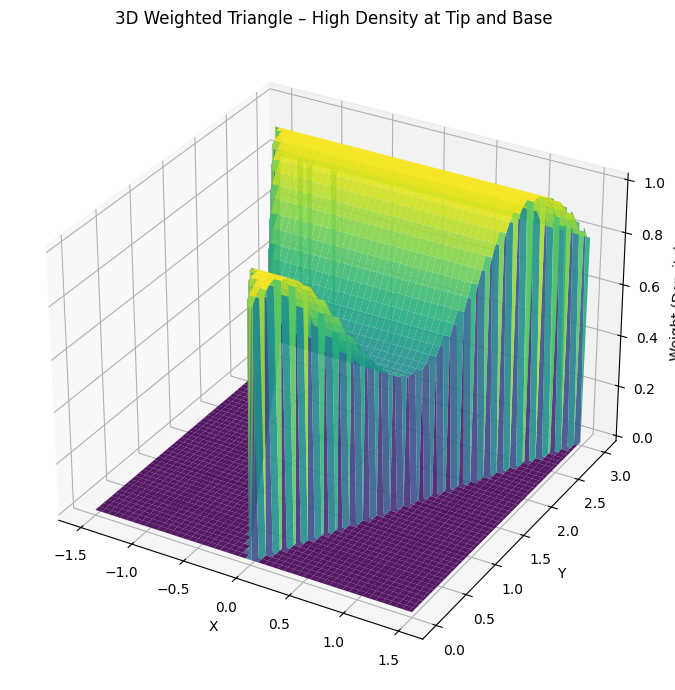

In [ ]:
#### WEIGHTED TRIANGLE MODEL

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a triangle in 2D space
# Points: ball (0,0), left base (-1, 3), right base (1, 3)
ball = np.array([0, 0])
left = np.array([-1.5, 3])
right = np.array([1.5, 3])

# Define a grid over the triangle bounding box
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)

# Barycentric coordinates to check if a point is inside triangle
def point_in_triangle(px, py, a, b, c):
    v0 = c - a
    v1 = b - a
    v2 = np.array([px, py]) - a

    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    denom = dot00 * dot11 - dot01 * dot01
    if denom == 0:
        return False

    u = (dot11 * dot02 - dot01 * dot12) / denom
    v = (dot00 * dot12 - dot01 * dot02) / denom
    return (u >= 0) and (v >= 0) and (u + v <= 1)

# Create the "height" function: high at y=0 and y=3, low in the middle
def triangle_density(x, y):
    norm_y = y / 3  # normalize y to 0-1
    return np.exp(-((norm_y - 0.15) ** 2) * 10) + np.exp(-((norm_y - 0.85) ** 2) * 10)

# Apply mask and height function
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if point_in_triangle(X[i, j], Y[i, j], ball, left, right):
            Z[i, j] = triangle_density(X[i, j], Y[i, j])

# Plot the triangle with the density profile
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Weight (Density)')
ax.set_title('3D Weighted Triangle – High Density at Tip and Base')

plt.tight_layout()
plt.show()


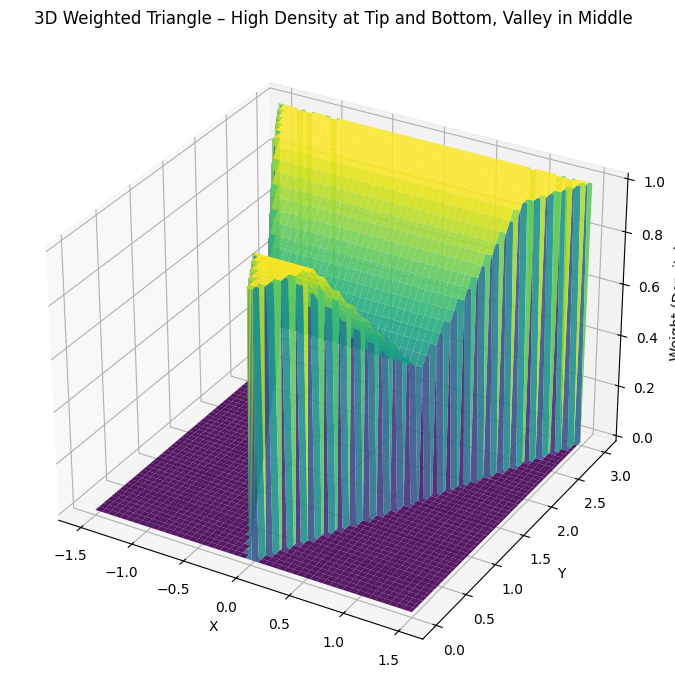

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a triangle in 2D space
# Points: ball (0,0), left base (-1.5, 3), right base (1.5, 3)
ball = np.array([0, 0])
left = np.array([-1.5, 3])
right = np.array([1.5, 3])

# Define a grid over the triangle bounding box
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)

# Barycentric coordinates to check if a point is inside a triangle
def point_in_triangle(px, py, a, b, c):
    v0 = c - a
    v1 = b - a
    v2 = np.array([px, py]) - a

    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    denom = dot00 * dot11 - dot01 * dot01
    if denom == 0:
        return False

    u = (dot11 * dot02 - dot01 * dot12) / denom
    v = (dot00 * dot12 - dot01 * dot02) / denom
    return (u >= 0) and (v >= 0) and (u + v <= 1)

# Modified density function:
def triangle_density_modified(x, y):
    norm_y = y / 3  # Normalize y between 0 and 1
    plateau_value = 1.0
    valley_value = 0.5
    # For the bottom (y close to 0) and tip (y close to 3), use plateau_value.
    if norm_y < 0.2:
        return plateau_value
    elif norm_y > 0.8:
        return plateau_value
    else:
        # For norm_y between 0.2 and 0.5, linearly transition from plateau_value to valley_value.
        if norm_y <= 0.5:
            return plateau_value + (valley_value - plateau_value) * ((norm_y - 0.2) / (0.5 - 0.2))
        # For norm_y between 0.5 and 0.8, transition from valley_value back to plateau_value.
        else:
            return valley_value + (plateau_value - valley_value) * ((norm_y - 0.5) / (0.8 - 0.5))

# Apply mask and modified density function over the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if point_in_triangle(X[i, j], Y[i, j], ball, left, right):
            Z[i, j] = triangle_density_modified(X[i, j], Y[i, j])

# Plot the 3D weighted triangle with the new density profile
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Weight (Density)')
ax.set_title('3D Weighted Triangle – High Density at Tip and Bottom, Valley in Middle')
plt.tight_layout()
plt.show()


<>:144: SyntaxWarning: invalid escape sequence '\d'
<>:144: SyntaxWarning: invalid escape sequence '\d'
/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_49233/331152216.py:144: SyntaxWarning: invalid escape sequence '\d'
  df_wide['max_score_player'] = df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)



Total decision changes: 27

    timestamp  reference_player_num  max_player_flat  max_player_weighted  \
0       97.72                    24               16                   18   
8      232.88                     2               16                   13   
9      243.00                    24               18                   12   
10     295.24                     2               12                   13   
11     295.96                     2               12                   13   
12     378.84                    24               16                   13   
16     544.56                    24                2                   23   
18     557.96                     2               16                   13   
23     710.72                     2               24                   13   
29     750.04                     2               23                   28   
30     861.56                    24               16                   12   
31     883.20                     2            

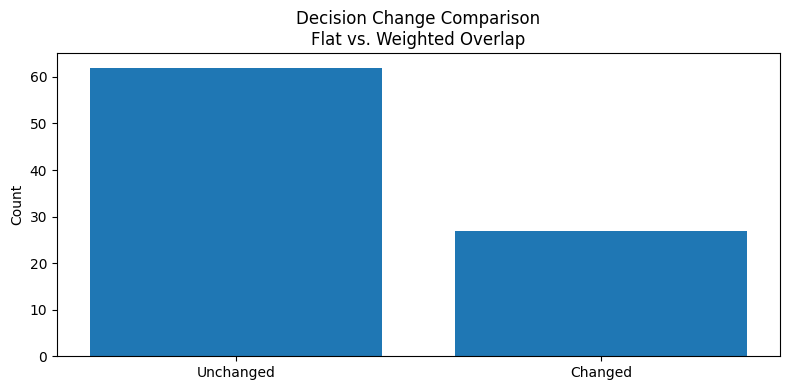

In [103]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

# === Weighted Overlap Calculation ===
def calculate_weighted_overlap_area(target_x, target_y, x_ball, y_ball, away_players, angle_degrees=40, circle_radius=2):
    dx, dy = target_x - x_ball, target_y - y_ball
    height = np.hypot(dx, dy)
    if height == 0:
        return 0.0

    trajectory_angle = np.arctan2(dy, dx)
    half_angle = np.radians(angle_degrees / 2)
    base_width = 2 * height * np.tan(half_angle)

    left_x = target_x + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
    left_y = target_y + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
    right_x = target_x + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
    right_y = target_y + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

    A = np.array([x_ball, y_ball])
    B = np.array([left_x, left_y])
    C = np.array([right_x, right_y])
    triangle = Polygon([A, B, C])

    def density_fn(y_ratio):
        return np.exp(-((y_ratio - 0.15) ** 2) * 10) + np.exp(-((y_ratio - 0.85) ** 2) * 10)

    total_density = 0.0
    for x, y in zip(away_players["x"], away_players["y"]):
        point = Point(x, y)
        if triangle.contains(point):
            proj = np.dot([x - x_ball, y - y_ball], [dx, dy]) / (height ** 2)
            y_ratio = np.clip(proj, 0, 1)
            total_density += density_fn(y_ratio)

    return total_density

# === Flat Overlap Calculation ===
def calculate_flat_overlap_area(target_x, target_y, x_ball, y_ball, away_players, angle_degrees=40, circle_radius=2):
    dx, dy = target_x - x_ball, target_y - y_ball
    height = np.hypot(dx, dy)
    if height == 0:
        return 0.0

    trajectory_angle = np.arctan2(dy, dx)
    half_angle_radians = np.radians(angle_degrees / 2)
    base_width = 2 * height * np.tan(half_angle_radians)

    left_x = target_x + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
    left_y = target_y + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
    right_x = target_x + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
    right_y = target_y + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

    triangle = Polygon([(left_x, left_y), (right_x, right_y), (x_ball, y_ball)])
    if not triangle.is_valid or triangle.area == 0:
        return 0.0

    return sum(
        triangle.intersection(Point(x, y).buffer(circle_radius)).area
        for x, y in zip(away_players["x"], away_players["y"])
    )

# === Scoring Functions ===
def score_exponential(overlap_area, distance_to_ball, ball_direction_x, alpha=1.0, beta=0.01, gamma=0.1):
    direction_bonus = gamma if ball_direction_x > 0 else -gamma
    penalty = alpha * overlap_area + beta * distance_to_ball
    return np.exp(-penalty + direction_bonus)

# === Main Scoring Engine ===
def run_decision_model(
    gps_data,
    player_subset,
    scoring_fn,
    overlap_fn,
    alpha=1.0,
    beta=0.01,
    gamma=0.1,
    angle_degrees=40
):
    results = []
    decisions = player_subset[player_subset["decision_making_point"] == 1].reset_index()

    for _, row in decisions.iterrows():
        current_time = row["time"]
        current_player = row["player_num"]
        x_ball, y_ball = row["ball_x"], row["ball_y"]

        players_now = gps_data[gps_data["time"] == current_time]
        teammates = players_now[(players_now["Team"] == "home") & (players_now["player_num"] != current_player)]
        opponents = players_now[players_now["Team"] == "away"]

        for _, teammate in teammates.iterrows():
            dist_to_ball = np.hypot(teammate["x"] - x_ball, teammate["y"] - y_ball)
            ball_direction_x = x_ball - teammate["x"]

            radius = 2 if dist_to_ball < 15 else 3 if dist_to_ball <= 25 else 6

            overlap = overlap_fn(
                target_x=teammate["x"],
                target_y=teammate["y"],
                x_ball=x_ball,
                y_ball=y_ball,
                away_players=opponents,
                angle_degrees=angle_degrees,
                circle_radius=radius
            )

            score = scoring_fn(
                overlap_area=overlap,
                distance_to_ball=dist_to_ball,
                ball_direction_x=ball_direction_x,
                alpha=alpha,
                beta=beta,
                gamma=gamma
            )

            results.append({
                "timestamp": current_time,
                "reference_player_num": current_player,
                "target_player_num": teammate["player_num"],
                "score": score
            })

    return pd.DataFrame(results)

# === Postprocessing to Wide Format ===
def summarize_results(results_df):
    df_wide = results_df.pivot_table(
        index=['timestamp', 'reference_player_num'],
        columns='target_player_num',
        values='score'
    ).reset_index()

    df_wide.columns = [
        f'score_to_player_{int(col)}' if isinstance(col, (int, float)) else col
        for col in df_wide.columns
    ]

    score_cols = [c for c in df_wide.columns if 'score_to_player_' in c]
    df_wide['max_score'] = df_wide[score_cols].max(axis=1)
    df_wide['max_score_player'] = df_wide[score_cols].idxmax(axis=1)
    df_wide['max_score_player'] = df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)

    return df_wide

# === Run both models ===
results_flat = run_decision_model(
    gps_data=gps_data,
    player_subset=player_24_2,
    scoring_fn=score_exponential,
    overlap_fn=calculate_flat_overlap_area
)

results_weighted = run_decision_model(
    gps_data=gps_data,
    player_subset=player_24_2,
    scoring_fn=score_exponential,
    overlap_fn=calculate_weighted_overlap_area
)

# === Compare Outputs ===
summary_flat = summarize_results(results_flat).rename(columns={
    'max_score': 'max_score_flat',
    'max_score_player': 'max_player_flat'
})
summary_weighted = summarize_results(results_weighted).rename(columns={
    'max_score': 'max_score_weighted',
    'max_score_player': 'max_player_weighted'
})

comparison_df = pd.merge(
    summary_flat[['timestamp', 'reference_player_num', 'max_score_flat', 'max_player_flat']],
    summary_weighted[['timestamp', 'reference_player_num', 'max_score_weighted', 'max_player_weighted']],
    on=['timestamp', 'reference_player_num']
)

comparison_df['decision_changed'] = comparison_df['max_player_flat'] != comparison_df['max_player_weighted']
comparison_df['score_difference'] = comparison_df['max_score_weighted'] - comparison_df['max_score_flat']

# === Output Changed Decisions ===
decision_changes = comparison_df[comparison_df['decision_changed']]
print(f"\nTotal decision changes: {len(decision_changes)}\n")
print(decision_changes[['timestamp', 'reference_player_num', 'max_player_flat', 'max_player_weighted', 'score_difference']])

# === Optional Plot ===
plt.figure(figsize=(8, 4))
plt.bar(['Unchanged', 'Changed'], [
    len(comparison_df) - len(decision_changes),
    len(decision_changes)
])
plt.ylabel("Count")
plt.title("Decision Change Comparison\nFlat vs. Weighted Overlap")
plt.tight_layout()
plt.show()



In [105]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

# === Defensive Pressure Calculation ===
def calculate_defensive_pressure(reference_x, reference_y, target_x, target_y, away_players, radius=3.0):
    dx = target_x - reference_x
    dy = target_y - reference_y
    length = np.hypot(dx, dy)
    if length == 0:
        return 0.0

    ux, uy = dx / length, dy / length
    back_center_x = reference_x - ux * radius
    back_center_y = reference_y - uy * radius

    pressure_score = 0.0
    for x, y in zip(away_players["x"], away_players["y"]):
        dx_op = x - back_center_x
        dy_op = y - back_center_y
        dist = np.hypot(dx_op, dy_op)
        if dist <= radius:
            if dx_op * ux + dy_op * uy < 0:
                pressure_score += 1 / (dist + 1e-3)  # Avoid division by zero
    return pressure_score

# === Scoring Function ===
def score_defensive_pressure(distance_to_ball, ball_direction_x, pressure_score, alpha=0.01, gamma=0.1, delta=0.5):
    penalty = alpha * distance_to_ball + delta * pressure_score
    direction_bonus = gamma if ball_direction_x > 0 else -gamma
    return np.exp(-penalty + direction_bonus)

# === Decision Model ===
def run_defensive_pressure_model(
    gps_data,
    player_subset,
    alpha=0.01,
    gamma=0.1,
    delta=0.5
):
    results = []
    decisions = player_subset[player_subset["decision_making_point"] == 1].reset_index()

    for _, row in decisions.iterrows():
        current_time = row["time"]
        current_player = row["player_num"]
        x_ball, y_ball = row["ball_x"], row["ball_y"]

        players_now = gps_data[gps_data["time"] == current_time]
        teammates = players_now[(players_now["Team"] == "home") & (players_now["player_num"] != current_player)]
        opponents = players_now[players_now["Team"] == "away"]

        for _, teammate in teammates.iterrows():
            dist_to_ball = np.hypot(teammate["x"] - x_ball, teammate["y"] - y_ball)
            ball_direction_x = x_ball - teammate["x"]

            pressure_score = calculate_defensive_pressure(
                reference_x=x_ball,
                reference_y=y_ball,
                target_x=teammate["x"],
                target_y=teammate["y"],
                away_players=opponents
            )

            score = score_defensive_pressure(
                distance_to_ball=dist_to_ball,
                ball_direction_x=ball_direction_x,
                pressure_score=pressure_score,
                alpha=alpha,
                gamma=gamma,
                delta=delta
            )

            results.append({
                "timestamp": current_time,
                "reference_player_num": current_player,
                "target_player_num": teammate["player_num"],
                "score": score
            })

    return pd.DataFrame(results)

# === Postprocessing ===
def summarize_results(results_df):
    df_wide = results_df.pivot_table(
        index=['timestamp', 'reference_player_num'],
        columns='target_player_num',
        values='score'
    ).reset_index()

    df_wide.columns = [
        f'score_to_player_{int(col)}' if isinstance(col, (int, float)) else col
        for col in df_wide.columns
    ]

    score_cols = [c for c in df_wide.columns if 'score_to_player_' in c]
    df_wide['max_score'] = df_wide[score_cols].max(axis=1)
    df_wide['max_score_player'] = df_wide[score_cols].idxmax(axis=1)
    df_wide['max_score_player'] = df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)

    return df_wide

# === Run the Defensive Pressure Model ===
results_defensive = run_defensive_pressure_model(
    gps_data=gps_data,
    player_subset=player_24_2,
    alpha=0.01,
    gamma=0.1,
    delta=0.5
)

results_defensive_summary = summarize_results(results_defensive)

# === Show Result Summary ===
print(results_defensive_summary[['timestamp', 'reference_player_num', 'max_score', 'max_score_player']])


    timestamp  reference_player_num  max_score  max_score_player
0       97.72                    24   0.937134                13
1      132.36                     2   0.931235                13
2      142.68                     2   0.951640                13
3      147.76                    24   0.948892                12
4      148.88                    24   1.089014                18
..        ...                   ...        ...               ...
84    2278.64                    24   1.086256                18
85    2314.68                     2   0.905465                28
86    2317.40                    24   0.920272                13
87    2319.00                    24   1.089226                18
88    2531.32                    24   0.922985                13

[89 rows x 4 columns]


<>:100: SyntaxWarning: invalid escape sequence '\d'
<>:100: SyntaxWarning: invalid escape sequence '\d'
/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_49233/1485819579.py:100: SyntaxWarning: invalid escape sequence '\d'
  df_wide['max_score_player'] = df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)


In [106]:
def plot_players_and_pressure_at_timestamp(gps_data, timestamp, angle_degrees=40):
    import matplotlib.patches as patches
    import numpy as np
    import matplotlib.pyplot as plt

    # Filter data for the given timestamp
    df = gps_data[gps_data["time"] == timestamp]
    if df.empty:
        print(f"No data found at timestamp {timestamp}.")
        return

    # Split teams
    home_players = df[df["Team"] == "home"]
    away_players = df[df["Team"] == "away"]

    if home_players.empty:
        print("No home players found. Cannot plot.")
        return

    # Ball position
    x_ball = df["ball_x"].iloc[0]
    y_ball = df["ball_y"].iloc[0]

    # Plot each pass from ball to home player
    team_colors = {"home": "blue", "away": "red"}

    for _, target_player in home_players.iterrows():
        dx = target_player["x"] - x_ball
        dy = target_player["y"] - y_ball
        trajectory_angle = np.arctan2(dy, dx)
        player_id = target_player["player_num"]
        height = np.hypot(dx, dy)
        half_angle_radians = np.radians(angle_degrees / 2)
        base_width = 2 * height * np.tan(half_angle_radians)

        left_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
        left_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
        right_x = target_player["x"] + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
        right_y = target_player["y"] + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

        # Plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot players and influence
        for _, row in df.iterrows():
            color = team_colors[row["Team"]]
            plt.scatter(row["x"], row["y"], color=color, alpha=0.8, label=row["Team"] if row["Team"] not in ax.get_legend_handles_labels()[1] else "")
            ax.add_patch(patches.Circle((row["x"], row["y"]), radius=4, color=color, alpha=0.2))
            plt.text(row["x"] + 0.5, row["y"] + 0.5, str(int(row["player_num"])), fontsize=9)

        # Ball
        plt.scatter(x_ball, y_ball, color="green", edgecolor="black", s=120, label="Ball")

        # Triangle visualization (directional cone)
        cone = patches.Polygon([(left_x, left_y), (right_x, right_y), (x_ball, y_ball)],
                               edgecolor="black", facecolor="gray", linestyle="dashed", alpha=0.3)
        ax.add_patch(cone)

        plt.xlim(0, 106)
        plt.ylim(0, 68)
        plt.gca().set_aspect('equal')
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title(f"Timestamp {timestamp} | Pass to Player {player_id}")
        plt.legend()
        plt.grid(True)
        plt.show()


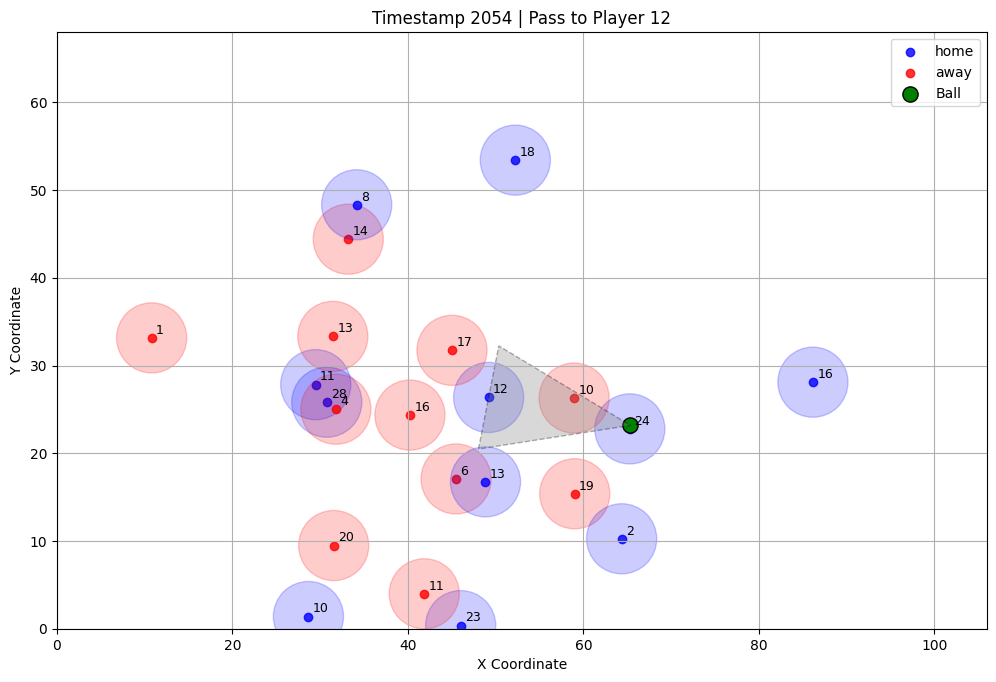

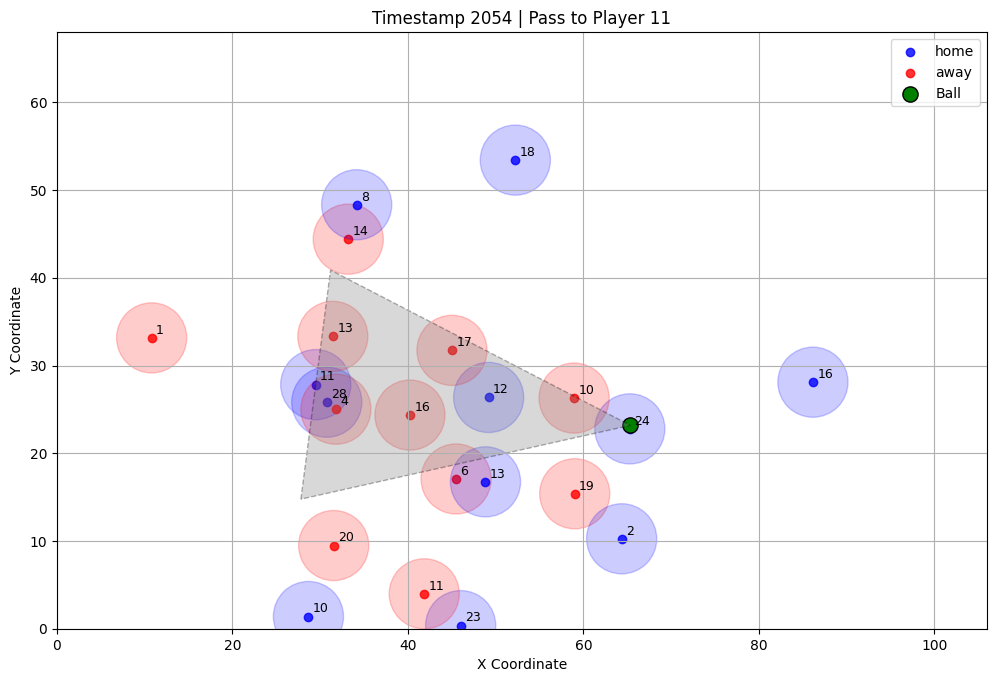

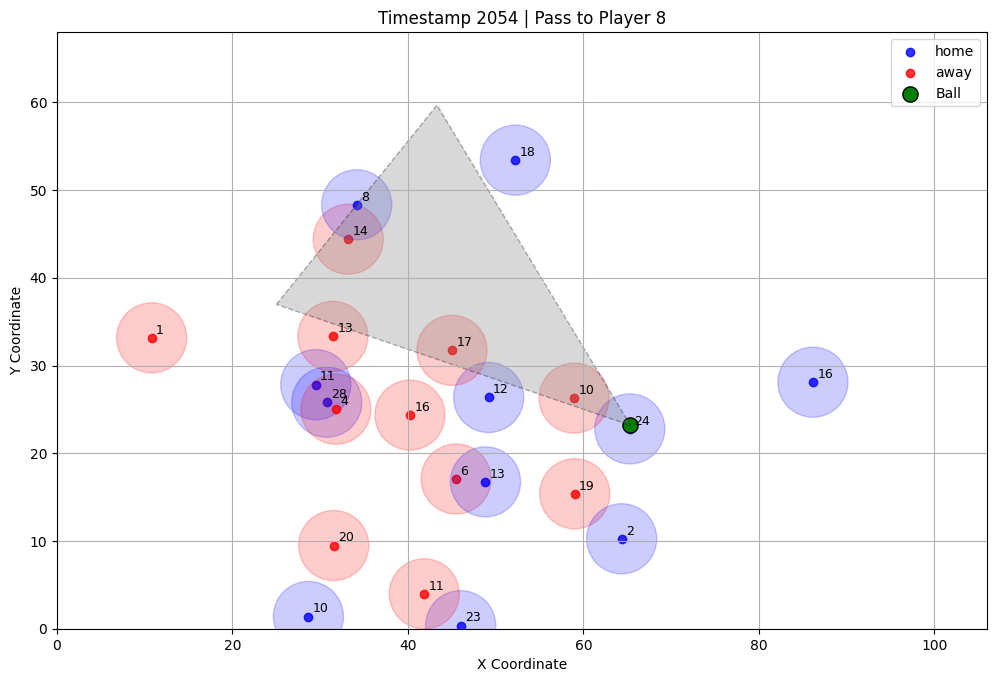

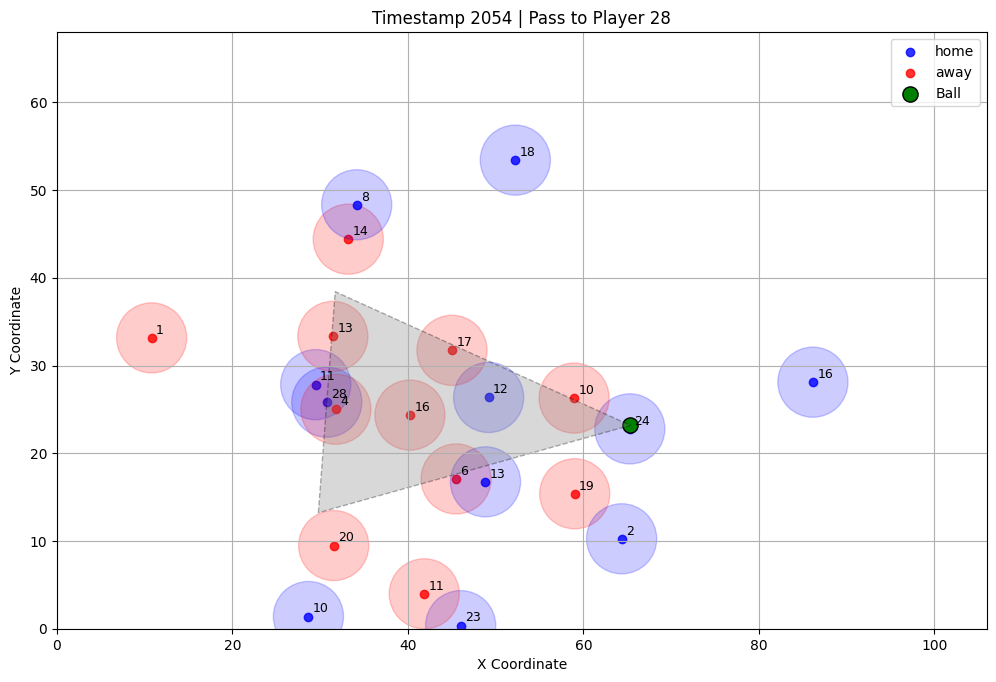

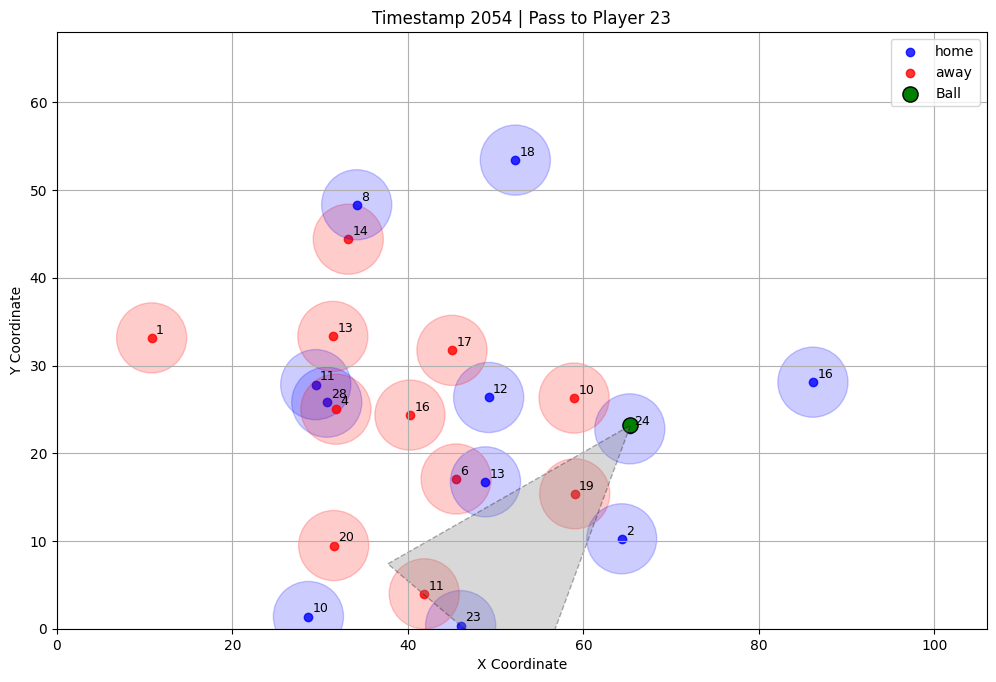

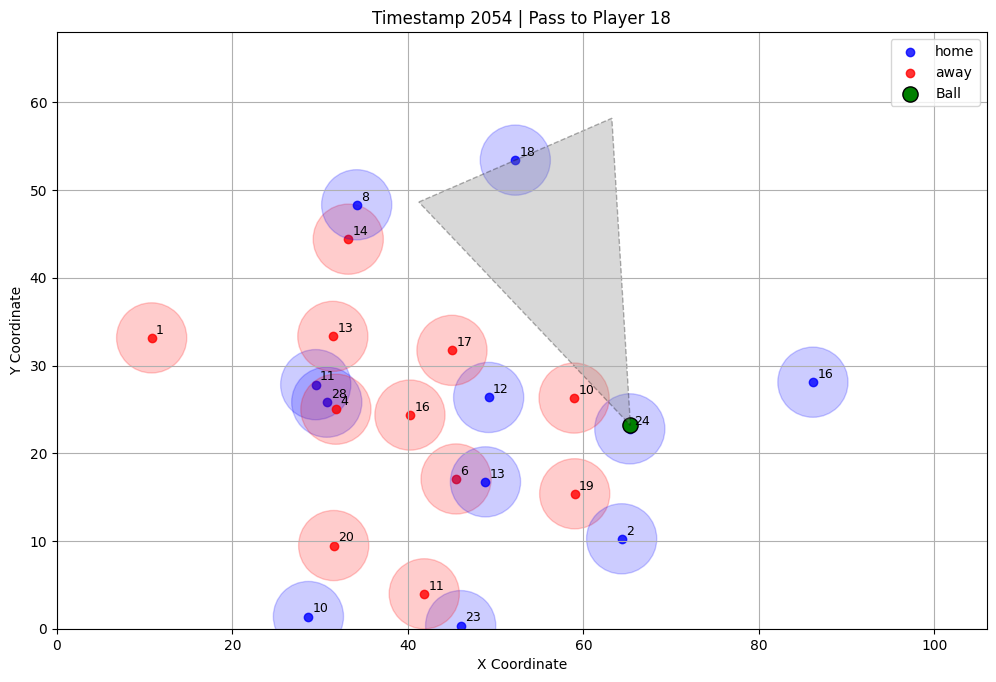

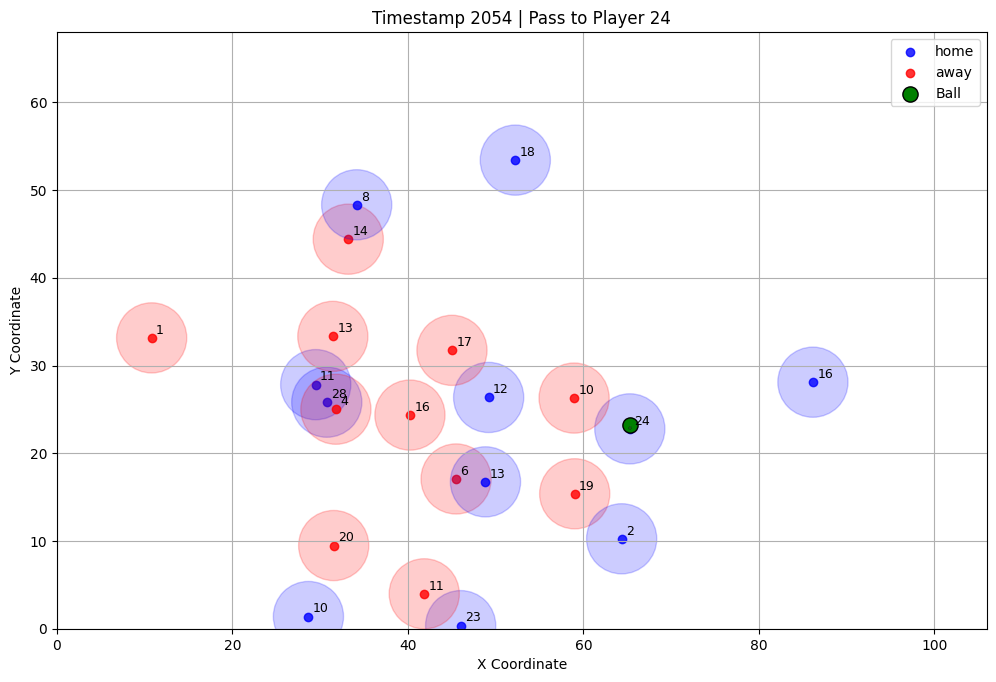

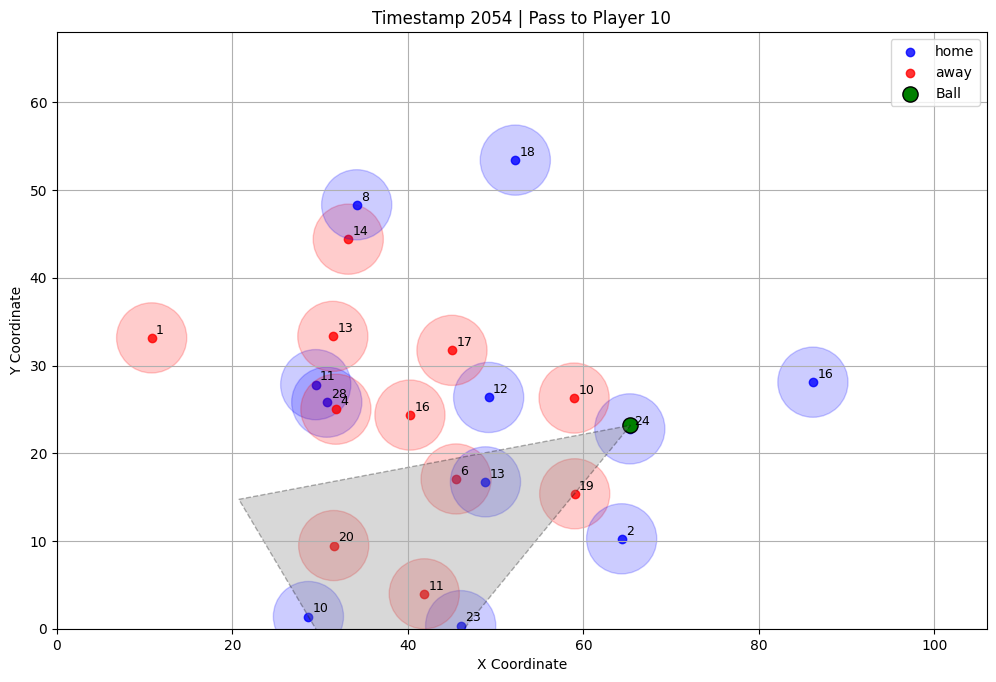

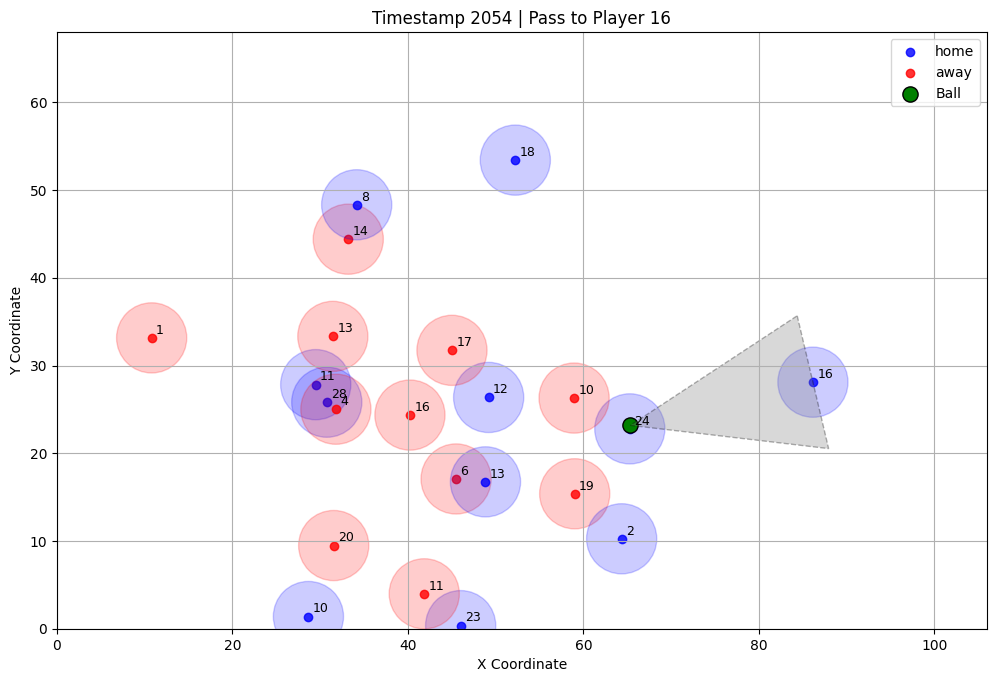

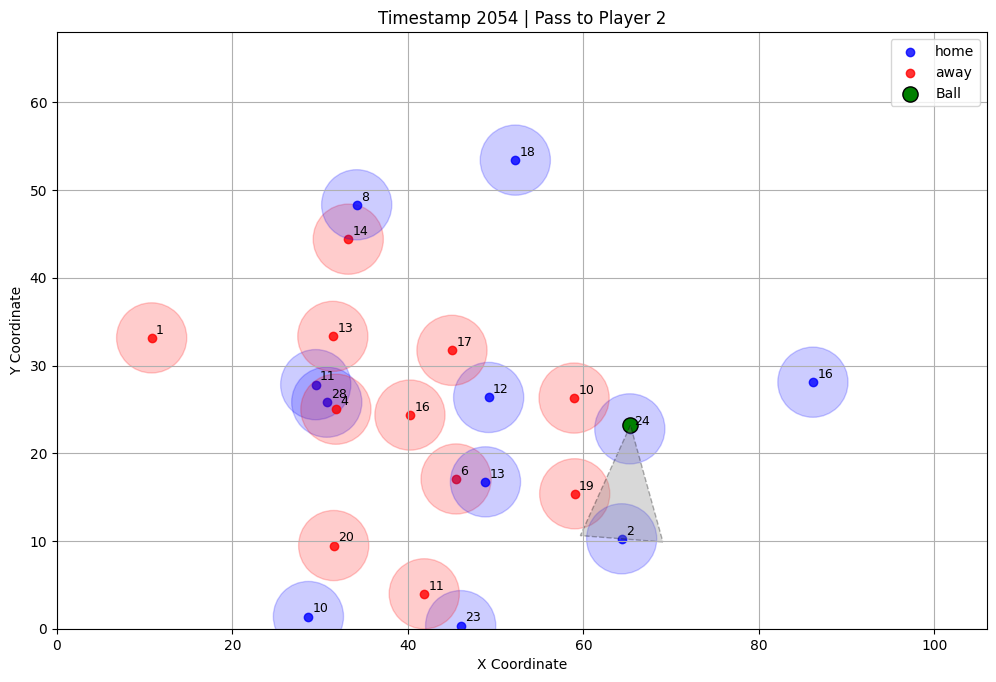

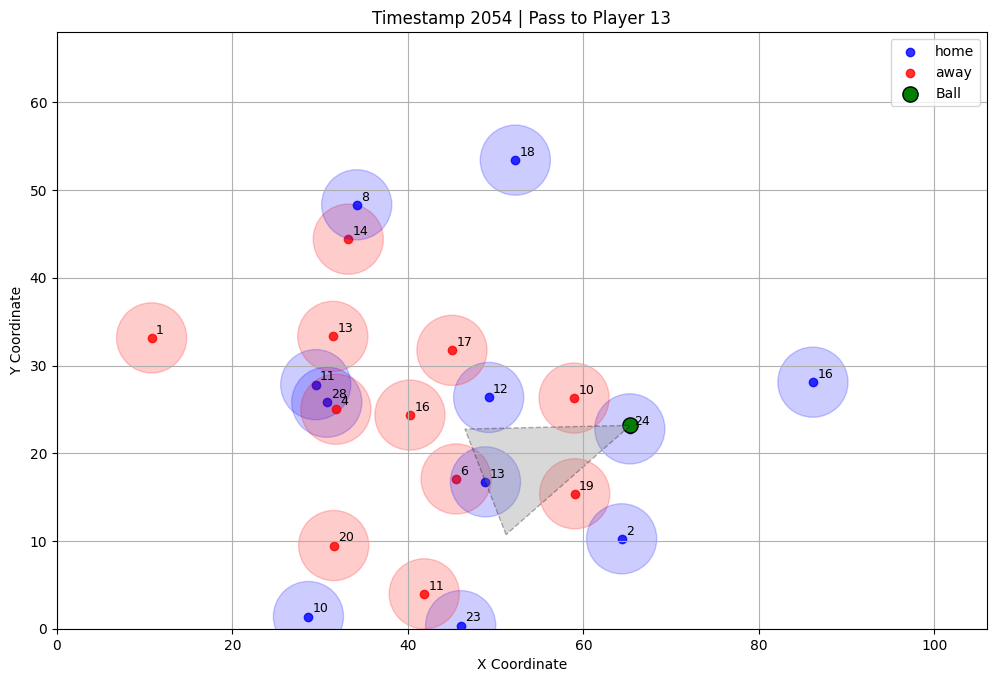

In [107]:
plot_players_and_pressure_at_timestamp(gps_data, 2054, angle_degrees=40)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define pressure as count of opponents within 8m
def calculate_pressure(player_x, player_y, opponent_positions, radius=8.0):
    distances = np.hypot(opponent_positions[:, 0] - player_x, opponent_positions[:, 1] - player_y)
    return np.sum(distances <= radius)

# Find link-out candidates
def find_link_out_candidates(gps_data, timestamp, ball_carrier_num):
    snapshot = gps_data[gps_data["time"] == timestamp]
    if snapshot.empty:
        return None, None, None

    ball_carrier = snapshot[snapshot["player_num"] == ball_carrier_num]
    if ball_carrier.empty:
        return None, None, None

    ball_x = ball_carrier["ball_x"].iloc[0]
    ball_y = ball_carrier["ball_y"].iloc[0]
    ball_pos = np.array([ball_x, ball_y])

    teammates = snapshot[(snapshot["Team"] == "home") & (snapshot["player_num"] != ball_carrier_num)]
    opponents = snapshot[snapshot["Team"] == "away"]
    opponent_positions = opponents[["x", "y"]].to_numpy()

    results = []

    for _, row in teammates.iterrows():
        dist = np.hypot(row["x"] - ball_x, row["y"] - ball_y)
        if 10 <= dist <= 30:
            pressure = calculate_pressure(row["x"], row["y"], opponent_positions)
            direction = row["x"] - ball_x
            results.append({
                "player_num": row["player_num"],
                "x": row["x"],
                "y": row["y"],
                "distance": dist,
                "pressure": pressure,
                "direction": direction
            })

    result_df = pd.DataFrame(results)

    # Find best candidates: low pressure & lateral/backward direction
    if not result_df.empty:
        result_df["score"] = -result_df["pressure"] + (result_df["direction"] < 10) * 1.0
        best_candidates = result_df.sort_values(by="score", ascending=False).head(3)
    else:
        best_candidates = pd.DataFrame()

    return ball_carrier, best_candidates, opponents

def plot_link_out_candidates_with_pressure(gps_data, timestamp, ball_carrier_num, best_candidates):
    import matplotlib.patches as patches
    import numpy as np
    import matplotlib.pyplot as plt

    # Filter data for the given timestamp
    df = gps_data[gps_data["time"] == timestamp]
    if df.empty:
        print(f"No data found at timestamp {timestamp}.")
        return

    home_players = df[df["Team"] == "home"]
    away_players = df[df["Team"] == "away"]

    if home_players.empty:
        print("No home players found. Cannot plot.")
        return

    # Ball position
    x_ball = df["ball_x"].iloc[0]
    y_ball = df["ball_y"].iloc[0]

    team_colors = {"home": "blue", "away": "red"}

    # Start plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot players and pressure bubbles
    for _, row in df.iterrows():
        color = team_colors[row["Team"]]
        ax.scatter(row["x"], row["y"], color=color, alpha=0.8, label=row["Team"] if row["Team"] not in ax.get_legend_handles_labels()[1] else "")
        ax.add_patch(patches.Circle((row["x"], row["y"]), radius=4, color=color, alpha=0.2))
        ax.text(row["x"] + 0.5, row["y"] + 0.5, str(int(row["player_num"])), fontsize=9)

    # Plot ball
    ax.scatter(x_ball, y_ball, color="green", edgecolor="black", s=120, label="Ball")

    # Plot link-out candidate numbers
    for rank, (_, row) in enumerate(best_candidates.iterrows(), start=1):
        ax.scatter(row["x"], row["y"], color="orange", s=150, edgecolors="black", zorder=3)
        ax.text(row["x"], row["y"], f"{rank}", fontsize=12, fontweight='bold', ha='center', va='center', color="black", zorder=4)

        # Draw dashed line from ball to candidate
        ax.plot([x_ball, row["x"]], [y_ball, row["y"]], color="orange", linestyle="--", linewidth=2)

    ax.set_xlim(0, 106)
    ax.set_ylim(0, 68)
    ax.set_aspect('equal')
    ax.set_title(f"Link-Out Candidates at Timestamp {timestamp} (Ball Carrier: {ball_carrier_num})")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend()
    ax.grid(True)
    plt.show()

timestamp = 2054
ball_carrier_num = 24

ball_carrier, best_candidates, opponents = find_link_out_candidates(gps_data, timestamp, ball_carrier_num)

if best_candidates is not None:
    plot_link_out_candidates_with_pressure(gps_data, timestamp, ball_carrier_num, best_candidates)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define pressure as count of opponents within 8m
def calculate_pressure(player_x, player_y, opponent_positions, radius=8.0):
    distances = np.hypot(opponent_positions[:, 0] - player_x, opponent_positions[:, 1] - player_y)
    return np.sum(distances <= radius)

# Find link-out candidates with the condition that the candidate's x-coordinate is less than the maximum x among opponents
def find_link_out_candidates(gps_data, timestamp, ball_carrier_num):
    snapshot = gps_data[gps_data["time"] == timestamp]
    if snapshot.empty:
        return None, None, None

    ball_carrier = snapshot[snapshot["player_num"] == ball_carrier_num]
    if ball_carrier.empty:
        return None, None, None

    ball_x = ball_carrier["ball_x"].iloc[0]
    ball_y = ball_carrier["ball_y"].iloc[0]

    # Get home teammates (excluding the ball carrier)
    teammates = snapshot[(snapshot["Team"] == "home") & (snapshot["player_num"] != ball_carrier_num)]
    # Get opponents
    opponents = snapshot[snapshot["Team"] == "away"]
    opponent_positions = opponents[["x", "y"]].to_numpy()

    # New condition: only include home players whose x is less than the maximum x of opponents.
    max_x_opponent = opponents["x"].max()

    results = []
    for _, row in teammates.iterrows():
        # Candidate must have x-coordinate less than max_x_opponent.
        if row["x"] >= max_x_opponent:
            continue

        dist = np.hypot(row["x"] - ball_x, row["y"] - ball_y)
        # Only consider candidates within 10 to 25 meters (e.g., excluding player 18 if too far)
        if 10 <= dist <= 25:
            pressure = calculate_pressure(row["x"], row["y"], opponent_positions)
            direction = row["x"] - ball_x  # positive value indicates forward progress
            results.append({
                "player_num": row["player_num"],
                "x": row["x"],
                "y": row["y"],
                "distance": dist,
                "pressure": pressure,
                "direction": direction
            })

    result_df = pd.DataFrame(results)

    # Score candidates: lower pressure is better; add a bonus if the candidate isn't too far forward (direction < 10)
    if not result_df.empty:
        result_df["score"] = -result_df["pressure"] + (result_df["direction"] < 10) * 1.0
        best_candidates = result_df.sort_values(by="score", ascending=False).head(3)
    else:
        best_candidates = pd.DataFrame()

    return ball_carrier, best_candidates, opponents

def plot_link_out_candidates_with_pressure(gps_data, timestamp, ball_carrier_num, best_candidates):
    # Filter data for the given timestamp
    df = gps_data[gps_data["time"] == timestamp]
    if df.empty:
        print(f"No data found at timestamp {timestamp}.")
        return

    home_players = df[df["Team"] == "home"]
    away_players = df[df["Team"] == "away"]

    if home_players.empty:
        print("No home players found. Cannot plot.")
        return

    # Ball position
    x_ball = df["ball_x"].iloc[0]
    y_ball = df["ball_y"].iloc[0]

    team_colors = {"home": "blue", "away": "red"}

    # Compute max_x among opponents for visual reference
    max_x_opponent = away_players["x"].max()

    # Start plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all players and their pressure bubbles
    for _, row in df.iterrows():
        color = team_colors[row["Team"]]
        ax.scatter(row["x"], row["y"], color=color, alpha=0.8, 
                   label=row["Team"] if row["Team"] not in ax.get_legend_handles_labels()[1] else "")
        ax.add_patch(patches.Circle((row["x"], row["y"]), radius=4, color=color, alpha=0.2))
        ax.text(row["x"] + 0.5, row["y"] + 0.5, str(int(row["player_num"])), fontsize=9)

    # Plot ball
    ax.scatter(x_ball, y_ball, color="green", edgecolor="black", s=120, label="Ball")

    # Draw vertical line at max_x_opponent for reference
    ax.axvline(x=max_x_opponent, color="magenta", linestyle="--", label="Max Opponent X")

    # Highlight link-out candidates with orange markers, number them, and draw dashed lines from the ball
    for rank, (_, row) in enumerate(best_candidates.iterrows(), start=1):
        ax.scatter(row["x"], row["y"], color="orange", s=150, edgecolors="black", zorder=3)
        ax.text(row["x"], row["y"], f"{rank}", fontsize=12, fontweight='bold',
                ha='center', va='center', color="black", zorder=4)
        ax.plot([x_ball, row["x"]], [y_ball, row["y"]], color="orange", linestyle="--", linewidth=2)

    ax.set_xlim(0, 106)
    ax.set_ylim(0, 68)
    ax.set_aspect("equal")
    ax.set_title(f"Link-Out Candidates at Timestamp {timestamp} (Ball Carrier: {ball_carrier_num})")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend()
    ax.grid(True)
    plt.show()

timestamp = 1838 #2054
ball_carrier_num = 24

ball_carrier, best_candidates, opponents = find_link_out_candidates(gps_data, timestamp, ball_carrier_num)

if best_candidates is not None:
    plot_link_out_candidates_with_pressure(gps_data, timestamp, ball_carrier_num, best_candidates)


In [113]:
decision_points_24 = pd.read_csv("/Users/annadaugaard/Desktop/VFF/explore/deciision_points_24.csv")

In [115]:
len(decision_points_24)

48

In [132]:
annotations = pd.read_csv("spiller_24_renskrevet.csv",sep=";")

In [134]:
annotations = annotations[annotations["Type"] == "LINK"]

In [ ]:
df = only_24.drop(index=[3,6,17,20,25,30,34,40,42,44,45,47])

In [135]:
annotations

,Picture_id,player_num,Type,preference
1,1,12,LINK,2
4,4,18,LINK,1
6,5,13,LINK,1
11,9,18,LINK,1
12,9,13,LINK,2
25,23,13,LINK,1
27,26,13,LINK,1
30,29,13,LINK,1
37,38,13,LINK,1


In [137]:
indexes = []
best_candidatess = []
for idx, row in decision_points_24.iterrows():

    timestamp = row["time"] #2054
    ball_carrier_num = 24

    ball_carrier, best_candidates, opponents = find_link_out_candidates(gps_data, timestamp, ball_carrier_num)
    best_candidatess.append(best_candidates)

    #if best_candidates is not None:
    #    plot_link_out_candidates_with_pressure(gps_data, timestamp, ball_carrier_num, best_candidates)
